# Implement Kalman model using FastAI

> need to implement custom data preparation pipeline and loss function 

## Data Preparation

The aim of the data preparation pipeline is to:
- take the original time series and split it into time blocks
- for each block generate a random gap (need to figure out the properties of the gap)
- split some time blocks for testing

the input of the pipeline is:
- a dataframe containing all observations

the input of the model is:
- observed data (potentially containing NaN where data is missing)
- missing data mask (which is telling where the data is missing)
- the data needs to be standardized

In [ ]:
#| hide
#| default_exp kalman.fastai

In [ ]:
import torch

In [ ]:
from fastai.tabular.core import *
from fastai.data.core import *

In [ ]:
from fastcore.transform import *
from fastcore.basics import *
from fastcore.foundation import *
from fastcore.all import *

In [ ]:
from fastai.tabular import *

In [ ]:
from meteo_imp.data import read_fluxnet_csv, hai_path

In [ ]:
from collections import namedtuple

In [ ]:
hai = read_fluxnet_csv(hai_path, None)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class MaskedTensor(fastuple):
    pass

In [ ]:
class TimeSTensor(fastuple):
    """Multivariate TimeSeries PyTorch Tensor"""
    pass

In [ ]:
class MeteoImpTransform(ItemTransform):
    def __init__(self, df, block_len=200): 
        self.block_len = block_len
        n = len(df)
        for i in range(0, n, block_len):
            end = i+block_len
            end = end if end < n else n
            time_block = torch.tensor(df[i:i+block_len].to_numpy())
            self.blocks.append(time_block) # does this copy memory?
        
    def encodes(self, i) -> MaskedTensor:
        
        block = self.blocks[i]
        
        start = i * self.block_len
        end = i+block_len
        end = end if end < n else n
        
        return MaskedTensor(block)
    


the first step is to transfrom the original dataframe into blocks of a specified `block_len`

two different strategies are possible:

- contigous blocks
- random block in the dataframe

In [ ]:
class BlockDfTransform(ItemTransform):
    """divide timeseries DataFrame into blocks"""
    def __init__(self, df, block_len=200): 
        self.df = df 
        self.block_len = block_len
        self.n = len(df)
        
    def encodes(self, i:int) -> pd.DataFrame:       
        start = i * self.block_len
        end = (i+1) * self.block_len
        assert end <= self.n 
        
        block = self.df[start:end]
        
        return block

In [ ]:
m = BlockDfTransform(hai[:100], 10)

In [ ]:
m

BlockDfTransform:
encodes: (int,object) -> encodes
decodes: 

In [ ]:
m(1)

,TA,SW_IN,VPD
TIMESTAMP_END,,,
200001011712.0,-0.23,0.00,0.138
200001011712.0,-0.23,0.00,0.122
200001011712.0,-0.22,0.00,0.098
200001011712.0,-0.24,0.00,0.066
200001011712.0,-0.23,0.00,0.044
200001011712.0,-0.22,0.00,0.026
200001011712.0,-0.19,0.45,0.016
200001011712.0,-0.14,3.70,0.010
200001011712.0,-0.03,7.26,0.006


In [ ]:
m(9)

,TA,SW_IN,VPD
TIMESTAMP_END,,,
200001028096.0,0.97,0.0,0.192
200001028096.0,0.85,0.0,0.149
200001028096.0,0.77,0.0,0.112
200001028096.0,0.63,0.0,0.075
200001028096.0,0.52,0.0,0.038
200001028096.0,0.48,0.0,0.021
200001028096.0,0.41,0.0,0.013
200001028096.0,0.29,0.0,0.004
200001028096.0,0.31,0.0,0.000


In [ ]:
#| exports
def _make_random_gap(
    gap_length: int, # The length of the gap
    total_length: int, # The total number of observations
    gap_start: int = None # Optional start of gap
): # (total_length) array of bools to indicicate if the data is missing or not
    "Add a continous gap of ginve length at random position"
    if(gap_length >= total_length):
        return np.repeat(True, total_length)
    gap_start = np.random.randint(total_length - gap_length) if gap_start is None else gap_start
    return np.hstack([
        np.repeat(False, gap_start),
        np.repeat(True, gap_length),
        np.repeat(False, total_length - (gap_length + gap_start))
    ])

In [ ]:
from fastcore.basics import *

In [ ]:
MaskedDf = namedtuple('MaskedDf', 'data mask')

In [ ]:
@patch
def show(self: MaskedDf, ax=None, ctx=None, **kwargs):
    ax = ifnone(ax,ctx)
    if ax is None: _,ax = plt.subplots()
    self.data.plot(ax=ax)

In [ ]:
class AddGapTransform(ItemTransform):
    """Adds a random gap to a `TimeSTensor`"""
    def __init__(self,
                variables,
                gap_length,
                ):
        store_attr()
    def encodes(self, df: pd.DataFrame):
        gap = _make_random_gap(self.gap_length, df.shape[0])
        mask = np.ones_like(df, dtype=bool)
        col_sel = L(*df.columns).argwhere(lambda x: x in self.variables)
        mask[np.argwhere(gap), col_sel] = False
        return MaskedDf(df, pd.DataFrame(mask))

In [ ]:
a_gap = AddGapTransform(['TA', 'VPD'], 5)
a_gap

AddGapTransform:
encodes: (DataFrame,object) -> encodes
decodes: 

In [ ]:
a_gap(m(1))

MaskedDf(data=                  TA  SW_IN    VPD
TIMESTAMP_END                     
200001011712.0 -0.23   0.00  0.138
200001011712.0 -0.23   0.00  0.122
200001011712.0 -0.22   0.00  0.098
200001011712.0 -0.24   0.00  0.066
200001011712.0 -0.23   0.00  0.044
200001011712.0 -0.22   0.00  0.026
200001011712.0 -0.19   0.45  0.016
200001011712.0 -0.14   3.70  0.010
200001011712.0 -0.03   7.26  0.006
200001011712.0  0.04  12.24  0.006, mask=       0     1      2
0   True  True   True
1   True  True   True
2   True  True   True
3  False  True  False
4  False  True  False
5  False  True  False
6  False  True  False
7  False  True  False
8   True  True   True
9   True  True   True)

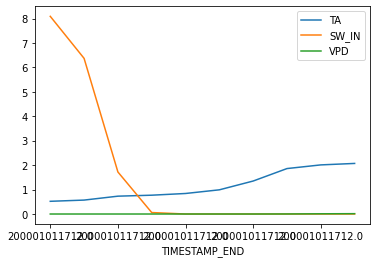

In [ ]:
a_gap(m(3)).show()

In [ ]:
idx = L(*m(1).columns).argwhere(lambda x: x in ['TA','SW_IN'])

In [ ]:
mask = np.ones_like(m(1), dtype=bool)

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
gap = _make_random_gap(2, 10, 2)

In [ ]:
gap

array([False, False,  True,  True, False, False, False, False, False,
       False])

In [ ]:
np.argwhere(gap)

array([[2],
       [3]])

In [ ]:
mask[np.argwhere(gap), idx] = False

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [False, False,  True],
       [False, False,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
mask[gap]

array([[False, False,  True],
       [False, False,  True]])

In [ ]:
# MaskedTensor = namedtuple('MaskedTensor', 'data mask')

class MaskedTensor(fastuple):
    pass

In [ ]:
class MaskedDf2Tensor(ItemTransform):
    def setups(self, items):
        self.columns = list(items[0].data.columns)
    def encodes(self, df: MaskedDf) -> MaskedTensor:
        data = torch.tensor(df[0].to_numpy())
        mask = torch.tensor(df[1].to_numpy())
        return MaskedTensor(data, mask)
        
    def decodes(self, x: MaskedTensor) -> MaskedDf:
        data = pd.DataFrame(x[0].detach().cpu().numpy(), columns = self.columns)
        mask = x[1].numpy()
        return MaskedDf(mask, data)

In [ ]:
tfms = TfmdLists([1,2,3], [BlockDfTransform(hai, 10), AddGapTransform(['TA','SW_IN'], 2), MaskedDf2Tensor ])

In [ ]:
tfms[1]

(tensor([[1.0000e-01, 1.6510e+01, 6.0000e-03],
         [1.8000e-01, 2.4730e+01, 1.1000e-02],
         [2.1000e-01, 4.7420e+01, 1.9000e-02],
         [2.3000e-01, 2.2050e+01, 1.4000e-02],
         [3.3000e-01, 1.8860e+01, 8.0000e-03],
         [4.1000e-01, 2.1100e+01, 6.0000e-03],
         [4.4000e-01, 2.8870e+01, 0.0000e+00],
         [4.8000e-01, 2.4220e+01, 0.0000e+00],
         [4.9000e-01, 2.4350e+01, 0.0000e+00],
         [5.1000e-01, 1.5680e+01, 0.0000e+00]]),
 tensor([[False, False,  True],
         [False, False,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]))

In [ ]:
type(tfms[0])

__main__.MaskedTensor

In [ ]:
from meteo_imp.utils import *

In [ ]:
from torch import Tensor

In [ ]:
def get_stats(df):
    return torch.tensor(df.mean(axis=0).to_numpy()), torch.tensor(df.std(axis=0).to_numpy())

In [ ]:
class NormalizeMasked(ItemTransform):
    "Normalize/denorm MaskedTensor column-wise "
    parameters,order = L('mean', 'std'),99
    def __init__(self, mean=None, std=None, axes=(0,)): store_attr()

    def encodes(self, x:MaskedTensor):
        return MaskedTensor((x[0]-self.mean) / self.std, x[1])

    def encodes(self, x):
        return MaskedTensor((x[0]-self.mean) / self.std, x[1])
    
    def decodes(self, x:ListNormal):
        mean = (x.std-self.mean) / self.std
        std = x.cov * self.std
        
        return ListNormal(mean, std)

In [ ]:
b = TfmdLists([0,1], [BlockDfTransform(hai, 10), AddGapTransform(['TA','SW_IN'], 2), MaskedDf2Tensor, NormalizeMasked(*get_stats(hai))]).dataloaders(bs=2).one_batch()[0]

In [ ]:
b[0].mean(0)

tensor([-1.1083, -0.5929, -0.7457])

In [ ]:
b[1].mean(0)

tensor([-1.0730, -0.5813, -0.7617])

In [ ]:
b.std(axis=(0,1))

tensor([0.0232, 0.0154, 0.0128])

### Split training / validation

In [ ]:
block_len = 10
block_ids = list(range(0, (len(hai) // block_len) - 1))[:10]
gap_len = 2

In [ ]:
from fastai.data.transforms import *

In [ ]:
pipeline = [BlockDfTransform(hai, block_len), AddGapTransform(['TA','SW_IN'], gap_len), MaskedDf2Tensor, NormalizeMasked(*get_stats(hai))]

In [ ]:
splits = RandomSplitter()(block_ids)

In [ ]:
tls = TfmdLists(block_ids, pipeline, splits=splits)

In [ ]:
tls

TfmdLists: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tfms - [BlockDfTransform:
encodes: (int,object) -> encodes
decodes: , AddGapTransform:
encodes: (DataFrame,object) -> encodes
decodes: , MaskedDf2Tensor:
encodes: (MaskedDf,object) -> encodes
decodes: (MaskedTensor,object) -> decodes
, NormalizeMasked:
encodes: (MaskedTensor,object) -> encodes
(object,object) -> encodes
decodes: (ListNormal,object) -> decodes
]

In [ ]:
type(tls[0])

__main__.MaskedTensor

In [ ]:
tls[0][0].shape, tls[0][1].shape

(torch.Size([10, 3]), torch.Size([10, 3]))

In [ ]:
dls = tls.dataloaders(bs=1)

In [ ]:
dls.one_batch()

(tensor([[[-1.0390, -0.5120, -0.7725],
          [-1.0289, -0.4717, -0.7714],
          [-1.0251, -0.3605, -0.7695],
          [-1.0226, -0.4848, -0.7707],
          [-1.0100, -0.5005, -0.7721],
          [-0.9999, -0.4895, -0.7725],
          [-0.9961, -0.4514, -0.7739],
          [-0.9911, -0.4742, -0.7739],
          [-0.9898, -0.4736, -0.7739],
          [-0.9873, -0.5161, -0.7739]]]),
 tensor([[[ True,  True,  True],
          [False, False,  True],
          [False, False,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]]]))

In [ ]:
next(iter(dls.train))

(tensor([[[-0.8195, -0.5929, -0.6876],
          [-0.8182, -0.5929, -0.6791],
          [-0.8510, -0.5929, -0.6924],
          [-0.8712, -0.5929, -0.7270],
          [-0.8838, -0.5929, -0.7309],
          [-0.8964, -0.5929, -0.7208],
          [-0.9204, -0.5929, -0.7121],
          [-0.9330, -0.5929, -0.7114],
          [-0.9494, -0.5929, -0.7224],
          [-0.9520, -0.5929, -0.7457]]]),
 tensor([[[False, False,  True],
          [False, False,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]]]))

In [ ]:
type(dls.one_batch())

__main__.MaskedTensor

In [ ]:
ds = Datasets(block_ids, [pipeline, pipeline], splits=splits)

In [ ]:
dls = ds.dataloaders(bs=1)

In [ ]:
dls.one_batch()

((tensor([[[-0.9848, -0.5842, -0.7638],
           [-0.9797, -0.5926, -0.7661],
           [-0.9873, -0.5929, -0.7666],
           [-1.0024, -0.5929, -0.7613],
           [-1.0075, -0.5929, -0.7453],
           [-1.0012, -0.5929, -0.7446],
           [-0.9684, -0.5929, -0.7279],
           [-0.9557, -0.5929, -0.7341],
           [-0.9494, -0.5929, -0.7386],
           [-0.9330, -0.5929, -0.7334]]]),
  tensor([[[ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [False, False,  True],
           [False, False,  True],
           [ True,  True,  True]]])),
 (tensor([[[-0.9848, -0.5842, -0.7638],
           [-0.9797, -0.5926, -0.7661],
           [-0.9873, -0.5929, -0.7666],
           [-1.0024, -0.5929, -0.7613],
           [-1.0075, -0.5929, -0.7453],
           [-1.0012, -0.5929, -0.7446],
           [-

## Model

### Forward

in order to the a pytorch module we need a forward method to the kalman filter

In [ ]:
from meteo_imp.kalman.filter import KalmanFilter
from torch.distributions import MultivariateNormal

In [ ]:
class ListNormal(fastuple):
    pass

In [ ]:
@patch
def forward(self: KalmanFilter, data: MaskedTensor):
    data, mask = data
    assert data.shape[0] == 1
    data = data.squeeze(0)
    filter_mask = mask.squeeze(0).all(1)
    times = torch.arange(data.shape[0])
    mean, cov = self.predict(data, mask=filter_mask, times=times)
    return ListNormal(mean, cov)

In [ ]:
model = KalmanFilter(n_dim_state = hai.shape[1], n_dim_obs=hai.shape[1])

In [ ]:
input = dls.one_batch()[0]
target = dls.one_batch()[1]

In [ ]:
pred = model(input)

In [ ]:
def imp_ll_loss(pred: ListNormal, target: MaskedTensor):
    "Log Likelihood loss for imputation (with MaskedTensor)"
    data, mask = target
    data, mask = data.squeeze(), mask.squeeze()

    means, covs = pred
    
    
    times = torch.argwhere(~mask.all(1))
    
    lls = torch.zeros(len(times))
    for i, t in enumerate(times):
        lls[i] = MultivariateNormal(means[t], covs[t]).log_prob(data[t:t+1])
    return -lls.sum() 
    
    # print(out, target)

In [ ]:
MultivariateNormal(pred[0][0], pred[1][0]).log_prob(target[0][0:1])

tensor([[-3.2953, -3.2938, -3.3014, -3.3112, -3.3145, -3.3153, -3.3191, -3.3220,
         -3.3280, -3.3331]], grad_fn=<SubBackward0>)

In [ ]:
mask = input[1].squeeze()

In [ ]:
mask.shape

torch.Size([10, 3])

In [ ]:
mask

tensor([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]])

In [ ]:
mask.all(1)

tensor([ True,  True,  True,  True,  True, False, False,  True,  True,  True])

In [ ]:
imp_ll_loss(pred, target)

tensor(6.6413, grad_fn=<NegBackward0>)

In [ ]:
from fastai.learner import * 

In [ ]:
learn = Learner(dls, model, loss_func=imp_ll_loss)

In [ ]:
from fastai.tabular.all import *

In [ ]:
import fastai

In [ ]:
learn.lr_find()

ValueError: Expected parameter covariance_matrix (Tensor of shape (1, 3, 3)) of distribution MultivariateNormal(loc: torch.Size([1, 3]), covariance_matrix: torch.Size([1, 3, 3])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[[ 0.6813, -0.0642,  0.3157],
         [-0.6620,  0.7018, -0.6869],
         [ 0.6872,  0.3085,  1.8245]]], grad_fn=<ExpandBackward0>)

In [ ]:
learn.fit(10, 0.007)

In [ ]:
learn.show_results()